# Imports

In [2]:
#imports
import pandas as pd
import numpy as np
from scipy import stats
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Feature Preparation

In [3]:
#read file
data = {}
for i in range(0,3):
    data[i] = pd.read_csv('/datasets/geo_data_'+str(i)+'.csv')
    print(data[i].info(),'\n',data[i].describe(),'\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 
                   f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entr

## Handling textual features

In [4]:
for i in range(0,3): print(data[i]['id'].nunique())

99990
99996
99996


In [5]:
id_counts = (data[1]['id'].value_counts())
id_counts[id_counts>1].index

Index(['LHZR0', 'bfPNe', '5ltQ6', 'wt4Uk'], dtype='object')

In [6]:
data[1].loc[data[1]['id'].isin(['bfPNe', 'wt4Uk', 'LHZR0', '5ltQ6']),:]

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


There are only 4-10 wells out of 10000 with 2 sets of coordinates so we can drop this column for training as it has very little meaning as a feature.

In [7]:
data_prep = {}
for i in range(0,3):
    data_prep[i] = data[i].drop('id', axis=1)

## Splitting Data

In [8]:
#splitting with 25% test
sets = defaultdict(lambda: defaultdict(dict))
for i in range(0,3):
    sets['train']['features'][i], \
    sets['test']['features'][i], \
    sets['train']['target'][i], \
    sets['test']['target'][i] = \
        train_test_split(data_prep[i].drop(['product'] , axis=1), data_prep[i]['product'], \
                         test_size=0.25, random_state=1234)
    #checking balance
    print('train mean: ', sets['train']['target'][i].mean(), 'test mean: ',sets['test']['target'][i].mean(),'\n' )

train mean:  92.4734489149376 test mean:  92.57965325518721 

train mean:  68.8324013194053 test mean:  68.80279604178406 

train mean:  95.00939984664652 test mean:  94.97180046006052 



## Scaling

In [9]:
#scaling numerical columns
col_to_scale = ['f0', 'f1', 'f2']
scaler = StandardScaler()
for i in range(0,3):
    scaler.fit(sets['train']['features'][i][col_to_scale])
    sets['train']['features'][i][col_to_scale] = scaler.transform(sets['train']['features'][i][col_to_scale])
    sets['test']['features'][i][col_to_scale] = scaler.transform(sets['test']['features'][i][col_to_scale])

# Training model

In [10]:
#training linear regressor
model = LinearRegression()

In [11]:
#training on training sets and making predictions

predicted = {}
predicted_train = {}
RMSE = defaultdict(dict)
for i in range(0,3):
    model.fit(sets['train']['features'][i],sets['train']['target'][i])
    predicted[i] = model.predict(sets['test']['features'][i])
    predicted_train[i]= model.predict(sets['train']['features'][i])
    RMSE['train'][i] = (mean_squared_error(sets['train']['target'][i],predicted_train[i] ))**0.5
    RMSE['test'][i] = (mean_squared_error(sets['test']['target'][i], predicted[i]))**0.5

In [12]:
#printing results
for i in range(0,3):
    print('Region: ',i,' Mean volume predicted: ', predicted[i].mean().round(4), 'RMSE: ', RMSE['test'][i].round(4))

Region:  0  Mean volume predicted:  92.4305 RMSE:  37.5624
Region:  1  Mean volume predicted:  68.8025 RMSE:  0.8939
Region:  2  Mean volume predicted:  94.9157 RMSE:  40.1032


Checking RMSE for the training set:

In [13]:
for i in range(0,3):
    print('Region: ',i, 'RMSE: ', RMSE['train'][i])

Region:  0 RMSE:  37.73536159035807
Region:  1 RMSE:  0.8891907009902921
Region:  2 RMSE:  40.04012247800077


## Model results analysis

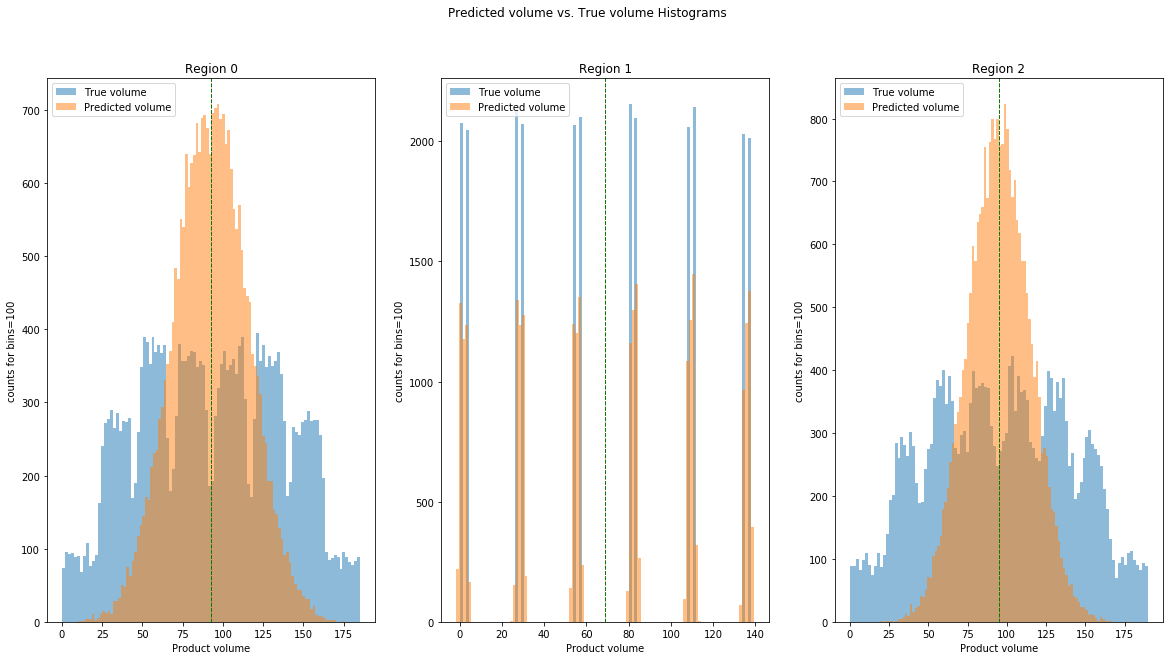

In [14]:
plt.figure(figsize=(20,10))
plt.suptitle('Predicted volume vs. True volume Histograms')
for i in range(0,3):
    plt.subplot(1,3,i+1)
    plt.hist(sets['test']['target'][i], bins=100,alpha=0.5, label='True volume')
    plt.axvline(sets['test']['target'][i].mean(), color='r', linestyle='dashed', linewidth=1)
    plt.hist(predicted[i], bins=100,alpha=0.5, label='Predicted volume')
    plt.axvline(predicted[i].mean(), color='g', linestyle='dashed', linewidth=1)
    plt.xlabel('Product volume')
    plt.ylabel('counts for bins=100')
    plt.legend(loc='upper left')
    plt.title('Region '+str(i))

- The RMSEs for regions 0,2 are (37,40) a little below the dataset STD (45) which is approximately 0.5 mean (92,95), small enough for the predictions to be of use but the model is not very good. It predicted gaussian approximation and missed the higher frequencies and the "flat head".
- The RMSE for region 1 is very low < 1, since the targets are much more discrete the model predicted better approximations.
- For regions 0,2 the models predicted twice the volume of the large majority of wells and much lower for less common targets. 
- For region 1 the model predicted lower than true targets 
- The RMSEs are the same for the training set itself.

# Preparing for profit Calculations

In [15]:
# values to be used
BUDGET_200_WELLS_DEV= 100*1000000 
NUMBER_OF_WELLS = 200
REVENUE_PRODUCT_UNIT= 4500
RISK_THRESHOLD = 0.25

profit from well = revenue from well - (cost + expenses) = revenue from 1 unit * product - development budget for 1 well

if profit = 0 (no losses) we need to find:

min product = development budget for 1 well / revenue from 1 unit

In [17]:
# calculating minimum reserves to have no losses
min_product = (BUDGET_200_WELLS_DEV/NUMBER_OF_WELLS)/(REVENUE_PRODUCT_UNIT)
min_product

111.11111111111111

In [18]:
# calculating the min_product percentiles in each region
for i in range(0,3):
    print('Region: ', str(i), 'risk of loss: ', stats.percentileofscore(data[i]['product'],min_product), '%')

Region:  0 risk of loss:  63.417 %
Region:  1 risk of loss:  83.463 %
Region:  2 risk of loss:  61.822 %


In regions 0,2 the min product for no losses is close to the mean value of ~ 90 and is achived in ~ 35% of the wells.

In region 1 the min product is much larger than the mean value of 68 and is achieved in ~ 15% of the wells.

# Calculating risks and profit for developing 200 wells in each region

In [19]:
def profit_from_set_of_wells(predictions, targets,  \
                             number_of_wells = NUMBER_OF_WELLS, \
                             budget_200_wells_dev = BUDGET_200_WELLS_DEV, \
                             revenue_product_unit = REVENUE_PRODUCT_UNIT):
    #calculates profit from a given number of targets according to predictions
    indices_max_predictions = predictions.sort_values(ascending=False).index[:number_of_wells]
    profit = revenue_product_unit * targets[indices_max_predictions].sum()-budget_200_wells_dev
    return profit

In [20]:
# bootstraping with 1000 samples for profit distribution
samples=1000
n=500
state = np.random.RandomState(12345)
profit = defaultdict(list)
for region in range(0,3):
    predictions = pd.Series(predicted[region], index=sets['test']['target'][region].index)
    for i in range(0,samples):
        target_sample = sets['test']['target'][region].sample(n=n, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        profit[region].append(profit_from_set_of_wells(predictions_sample, target_sample))
    profit[region] = pd.Series(profit[region])

In [21]:
#calculating average profit and 95% interval and risk of loses

for i in range(0,3):   
    print('Region: ', i, '\nAverage profit: ', profit[i].mean().round()/1000000,'M'\
          '\n95% confidence interval: ',  profit[i].quantile(0.025).round()/1000000,'M', ' - ', \
          profit[i].quantile(0.975).round()/1000000,'M', \
         '\nRisk of loses: ', stats.percentileofscore(profit[i],0),'%\n')

Region:  0 
Average profit:  5.904361 M
95% confidence interval:  0.037137 M  -  12.293066 M 
Risk of loses:  2.5 %

Region:  1 
Average profit:  6.2155 M
95% confidence interval:  1.394405 M  -  11.843728 M 
Risk of loses:  0.7 %

Region:  2 
Average profit:  5.65698 M
95% confidence interval:  -0.49444 M  -  11.778789 M 
Risk of loses:  3.6 %



The risk threshold is 2.5%, only regions 0,1 satisfies this condition. Region 1 has the highest average profit (and lower risk of 0.7%), thus this is the region that is recomended for development.